Author: Dr. Liantsoa F. Randrianjanahary

## Choose sample of 10 Antennas of HIRAX 

Objective function: Minimizes the variance of baseline lengths.

Random start: Antennas are randomly distributed over 100m x 100m.

Custom Nelder–Mead: We implement simplex reflection, expansion, contraction, and shrink steps.

Plots: Show initial random vs optimized close-packed layout

Add 2D Beam Pattern Simulation: Use the optimized positions to visualize the beam pattern ( B(u,v) = | sum_n exp( i 2π (u x_n + v y_n) ) |²)  


Initial Score: 592.7158828329665
Custom Nelder-Mead Score: 232.52942795621502
SciPy Nelder-Mead Score: 300.9432322838475


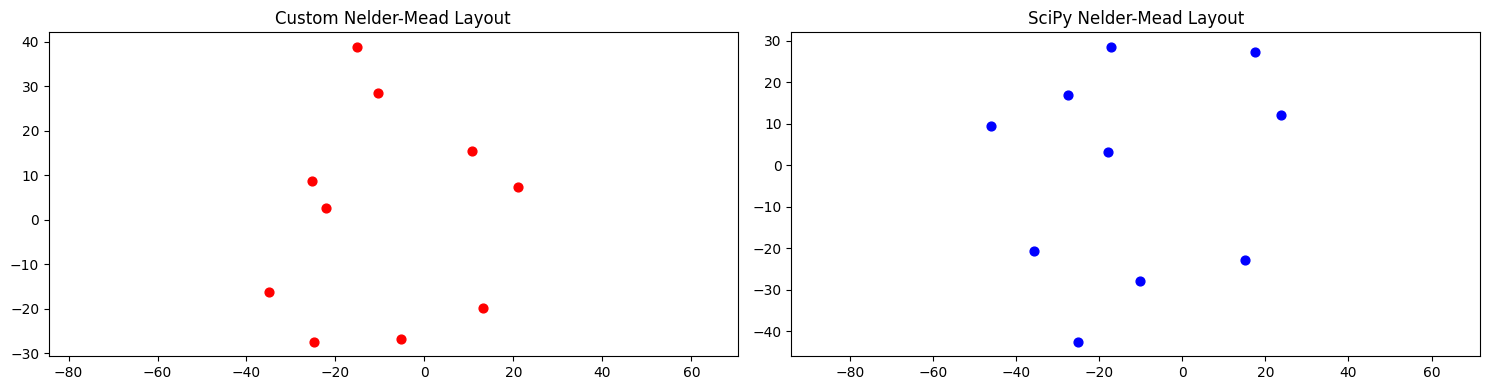

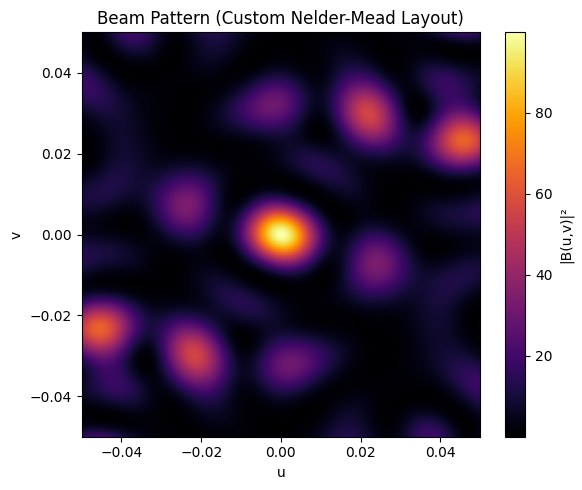

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# =====================================================
# 1. Objective Function
# =====================================================
def compute_baselines(positions):
    """Compute all unique pairwise baselines between antennas."""
    baselines = []
    for i in range(len(positions)):
        for j in range(i+1, len(positions)):
            baselines.append(positions[j] - positions[i])
    return np.array(baselines)

def baseline_alignment_score(params, N, array_size):
    """
    Objective function:
    Minimize the variance of baseline lengths to achieve aligned baselines.
    Includes penalties for out-of-bounds positions and antenna overlap.
    """
    positions = params.reshape(N, 2)
    baselines = compute_baselines(positions)
    baseline_lengths = np.linalg.norm(baselines, axis=1)
    score = np.var(baseline_lengths)
    
    # Out-of-bounds penalty
    outside = np.maximum(np.abs(positions) - array_size/2, 0)
    score += 10 * np.sum(outside**2)
    
    # Overlap penalty
    dists = np.linalg.norm(positions[:, None, :] - positions[None, :, :], axis=2)
    np.fill_diagonal(dists, np.inf)
    overlap_penalty = np.sum(1/(dists[dists < 6] + 1e-6))
    score += 100 * overlap_penalty
    
    return score

# =====================================================
# 2. Custom Nelder–Mead Algorithm
# =====================================================
def nelder_mead(func, x0, args=(), alpha=1, gamma=2, rho=0.5, sigma=0.5, max_iter=300, tol=1e-6):
    n = len(x0)
    simplex = [x0]
    for i in range(n):
        x = x0.copy()
        x[i] += 0.05 * (np.abs(x[i]) + 1e-4)
        simplex.append(x)
    simplex = np.array(simplex)
    
    for iteration in range(max_iter):
        values = np.array([func(x, *args) for x in simplex])
        order = np.argsort(values)
        simplex = simplex[order]
        values = values[order]
        
        if np.std(values) < tol:
            break
        
        centroid = np.mean(simplex[:-1], axis=0)
        xr = centroid + alpha * (centroid - simplex[-1])
        fr = func(xr, *args)
        
        if values[0] <= fr < values[-2]:
            simplex[-1] = xr
            continue
        
        if fr < values[0]:
            xe = centroid + gamma * (xr - centroid)
            fe = func(xe, *args)
            simplex[-1] = xe if fe < fr else xr
            continue
        
        xc = centroid + rho * (simplex[-1] - centroid)
        fc = func(xc, *args)
        if fc < values[-1]:
            simplex[-1] = xc
            continue
        
        best = simplex[0]
        simplex = best + sigma * (simplex - best)
    
    return simplex[0], func(simplex[0], *args)

# =====================================================
# 3. Beam Pattern Simulation
# =====================================================
def simulate_beam_pattern(positions, grid_size=256, uv_extent=0.05):
    """
    Compute beam pattern using Fourier response:
    B(u,v) = | sum_n exp( i 2π (u x_n + v y_n) ) |²
    """
    u = np.linspace(-uv_extent, uv_extent, grid_size)
    v = np.linspace(-uv_extent, uv_extent, grid_size)
    U, V = np.meshgrid(u, v)
    
    beam = np.zeros_like(U, dtype=complex)
    for (x, y) in positions:
        beam += np.exp(1j * 2 * np.pi * (U * x + V * y))
    return u, v, np.abs(beam)**2



# =====================================================
# 5. Run Comparison
# =====================================================
N = 10
array_size = 100
np.random.seed(42)
initial_positions = np.random.uniform(-array_size/2, array_size/2, size=(N, 2))
x0 = initial_positions.flatten()

# Custom Nelder-Mead
best_nm, val_nm = nelder_mead(baseline_alignment_score, x0, args=(N, array_size))

# SciPy Nelder-Mead
res_scipy = minimize(baseline_alignment_score, x0, args=(N, array_size),
                     method='Nelder-Mead', options={'maxiter': 300})
best_scipy = res_scipy.x
val_scipy = res_scipy.fun


print("Initial Score:", baseline_alignment_score(x0, N, array_size))
print("Custom Nelder-Mead Score:", val_nm)
print("SciPy Nelder-Mead Score:", val_scipy)


positions_nm = best_nm.reshape(N, 2)
positions_scipy = best_scipy.reshape(N, 2)


# =====================================================
# 6. Plot Layouts
# =====================================================
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(positions_nm[:, 0], positions_nm[:, 1], c='red', s=40)
plt.title("Custom Nelder-Mead Layout")
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(positions_scipy[:, 0], positions_scipy[:, 1], c='blue', s=40)
plt.title("SciPy Nelder-Mead Layout")
plt.axis('equal')

plt.axis('equal')
plt.tight_layout()
plt.show()

# =====================================================
# 7. Plot Beam Pattern for Custom Nelder-Mead
# =====================================================
u, v, beam = simulate_beam_pattern(positions_nm)
plt.figure(figsize=(6, 5))
plt.imshow(beam, extent=[u.min(), u.max(), v.min(), v.max()],
           origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='|B(u,v)|²')
plt.title('Beam Pattern (Custom Nelder-Mead Layout)')
plt.xlabel('u')
plt.ylabel('v')
plt.tight_layout()
plt.show()


# Exercise:

Apply the Nelder-Mead Algoirthm to minimize $\chi^2$ in order to estimate cosmological parameters such as $H_0$ and $\Omega_m$